In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split,ShuffleSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"]='0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
#NN-based model
from deepctr_torch.models import PNN
from deepctr_torch.models import CCPM

from deepctr_torch.models import WDL 
from deepctr_torch.models import DCN
from deepctr_torch.models import NFM
from deepctr_torch.models import DeepFM

#recent nn-based approach
from deepctr_torch.models import AFM
from deepctr_torch.models import xDeepFM
from deepctr_torch.inputs import SparseFeat,get_feature_names,DenseFeat,VarLenSparseFeat
import torch
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import mean_squared_error,recall_score,ndcg_score
import json
torch.cuda.is_available()


True

In [3]:
def Average(lst):
    return round(sum(lst) / len(lst),4) 


def split_data(x):
    if len(str(x)) == 1:
        key_ans = list(x)
    else:
        key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

# movielens

In [4]:
sparse_features = ['user', 'movie', 'age', 'occupation']
target = ['rating']
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

key2index = {}
genres_list = list(map(split, data['genre'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )

fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=4) for feat in sparse_features]

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
                            key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean')]  
# Notice : value 0 is for padding for sequence input feature

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dict = {"IPNN":PNN(dnn_feature_columns,use_inner=True,use_outter=False,task='regression',device=device),
              "OPNN":PNN(dnn_feature_columns,use_inner=False,use_outter=True,task='regression',device=device),
              "PNN":PNN(dnn_feature_columns,use_inner=True,use_outter=True,task='regression',device=device),
              "CCPM":CCPM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "WDL":WDL(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "DCN":DCN(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "NFM":NFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "DeepFM":DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "AFM":AFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "xDeepFM":xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device)}

In [ ]:
rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=42)
store_final_result = {}
for model_name,model_ in model_dict.items():
        
    RMSE_M = []
    recall_M = []
    NDCG_M = []
    print(model_name)
    # 3.generate input data for model
    for i, (train_index, test_index) in enumerate(rs.split(data)):
        model_dict = {"IPNN":PNN(dnn_feature_columns,use_inner=True,use_outter=False,task='regression',device=device),
                      "OPNN":PNN(dnn_feature_columns,use_inner=False,use_outter=True,task='regression',device=device),
                      "PNN":PNN(dnn_feature_columns,use_inner=True,use_outter=True,task='regression',device=device),
                      "CCPM":CCPM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "WDL":WDL(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "DCN":DCN(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "NFM":NFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "DeepFM":DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "AFM":AFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "xDeepFM":xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device)}
        X_train, y_train = data.iloc[train_index], data.iloc[train_index]['rating']  
        X_test, y_test = data.iloc[test_index], data.iloc[test_index]['rating']

        train_model_input = {name: X_train[name] for name in sparse_features}
        train_model_input["genres"] = genres_list[train_index]
        test_model_input = {name: X_test[name] for name in sparse_features}
        test_model_input["genres"] = genres_list[test_index]
        
        model = model_dict[model_name]

        model.compile("adam", "mse", metrics=['mse'], )
        history = model.fit(train_model_input,y_train.values,batch_size=256,epochs=15,verbose=2,validation_split=0.2)
        pred_ans = model.predict(test_model_input, batch_size=256)

        RMSE = mean_squared_error(pred_ans,y_test, squared=False)
        RMSE_M.append(RMSE)
        recall = recall_score(np.round(pred_ans),y_test, average='micro')
        recall_M.append(recall)
        NDCG = ndcg_score(pred_ans.reshape(1, -1),y_test.values.reshape(1, -1), k=10)
        NDCG_M.append(NDCG) 
        print(f"RMSE: {RMSE}, Recall: {recall}, NDCG: {NDCG}")
    print(f"Average RMSE: {Average(RMSE_M)}, Average Recall: {Average(recall_M)}, Average NDCG: {Average(NDCG_M)}")    
    store_final_result[model_name] = f"Average RMSE: {Average(RMSE_M)}, Average Recall: {Average(recall_M)}, Average NDCG: {Average(NDCG_M)}"

#0.8353, Average Recall: 0.4685, Average NDCG: 0.7758
with open('final_result.txt', 'w') as file:
    file.write(json.dumps(store_final_result))

# yelp

In [3]:
# data = pd.read_csv("../hw3_data/Movielens/movielens_sample.csv")
data = pd.read_csv("../hw3_data/Yelp/Yelp_sample.csv")

data

,user,business,city,category,compliment,rating
0,1,8391,31,45|200|328,0,5
1,1,8971,35,45|200|328,0,5
2,2,186,31,187|306|407,1|2|3|4|5|6|7|8|9|11,5
3,2,205,31,407|435,1|2|3|4|5|6|7|8|9|11,5
4,2,209,31,45|76|328|407,1|2|3|4|5|6|7|8|9|11,4
...,...,...,...,...,...,...
185385,16238,13256,26,68|407,7|9|11,5
185386,16239,2580,35,16|45|328|407,0,4
185387,16239,10525,35,45|306|328|407|443,0,1
185388,16239,12714,35,16|45|65|328|407,0,4


In [4]:
sparse_features = ['user', 'business', 'city']
dense_features = ['category', 'compliment']

target = ['rating']
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

key2index = {}
category_list = list(map(split_data, data['category'].values))
category_key2index = key2index
category_length = np.array(list(map(len, category_list)))
max_len = max(category_length)
# Notice : padding=`post`
category_list = pad_sequences(category_list, maxlen=max_len, padding='post', )

key2index = {}
compliment_list = list(map(split_data, data['compliment'].values))
compliment_key2index = key2index 
compliment_length = np.array(list(map(len, compliment_list)))
max_len = max(compliment_length)
# Notice : padding=`post`
compliment_list = pad_sequences(compliment_list, maxlen=max_len, padding='post', )

fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=4) for feat in sparse_features]
varlen_feature_columns = [VarLenSparseFeat(SparseFeat( 'category', vocabulary_size=len(category_key2index) + 1, embedding_dim=4) , maxlen=max_len, combiner='mean')] 
varlen_feature_columns.extend([VarLenSparseFeat(SparseFeat( 'compliment', vocabulary_size=len(compliment_key2index) + 1, embedding_dim=4) , maxlen=max_len, combiner='mean')])  
# Notice : value 0 is for padding for sequence input feature

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dict = {"IPNN":PNN(dnn_feature_columns,use_inner=True,use_outter=False,task='regression',device=device),
              "OPNN":PNN(dnn_feature_columns,use_inner=False,use_outter=True,task='regression',device=device),
              "PNN":PNN(dnn_feature_columns,use_inner=True,use_outter=True,task='regression',device=device),
              "CCPM":CCPM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
              "WDL":WDL(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "DCN":DCN(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "NFM":NFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "DeepFM":DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "AFM":AFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "xDeepFM":xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device)}

In [ ]:
rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=42)
store_final_result = {}
for model_name,model_ in model_dict.items():
        
    RMSE_M = []
    recall_M = []
    NDCG_M = []
    print(model_name)
    # 3.generate input data for model
    for i, (train_index, test_index) in enumerate(rs.split(data)):
        model_dict = {"IPNN":PNN(dnn_feature_columns,use_inner=True,use_outter=False,task='regression',device=device),
                      "OPNN":PNN(dnn_feature_columns,use_inner=False,use_outter=True,task='regression',device=device),
                      "PNN":PNN(dnn_feature_columns,use_inner=True,use_outter=True,task='regression',device=device),
                      "CCPM":CCPM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "WDL":WDL(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "DCN":DCN(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "NFM":NFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "DeepFM":DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "AFM":AFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "xDeepFM":xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device)}
        X_train, y_train = data.iloc[train_index], data.iloc[train_index]['rating']  
        X_test, y_test = data.iloc[test_index], data.iloc[test_index]['rating']

        train_model_input = {name: X_train[name] for name in sparse_features}
        train_model_input["category"] = category_list[train_index]
        train_model_input["compliment"] = compliment_list[train_index]
        
        test_model_input = {name: X_test[name] for name in sparse_features}
        test_model_input["category"] = category_list[test_index]
        test_model_input["compliment"] = compliment_list[test_index]
        
        model = model_dict[model_name]

        model.compile("adam", "mse", metrics=['mse','recall'], )
        history = model.fit(train_model_input,y_train.values,batch_size=256,epochs=6,verbose=2,validation_split=0.2)
        pred_ans = model.predict(test_model_input, batch_size=256)

        RMSE = mean_squared_error(pred_ans,y_test, squared=False)
        RMSE_M.append(RMSE)
        recall = recall_score(np.round(pred_ans),y_test, average='micro')
        recall_M.append(recall)
        NDCG = ndcg_score(pred_ans.reshape(1, -1),y_test.values.reshape(1, -1), k=10)
        NDCG_M.append(NDCG) 
        print(f"RMSE: {RMSE}, Recall: {recall}, NDCG: {NDCG}")
    print(f"Average RMSE: {Average(RMSE_M)}, Average Recall: {Average(recall_M)}, Average NDCG: {Average(NDCG_M)}")    
    store_final_result[model_name] = f"Average RMSE: {Average(RMSE_M)}, Average Recall: {Average(recall_M)}, Average NDCG: {Average(NDCG_M)}"

#0.8353, Average Recall: 0.4685, Average NDCG: 0.7758
with open('final_result_yelp.txt', 'w') as file:
    file.write(json.dumps(store_final_result))

dict_keys(['loss', 'mse', 'val_mse'])


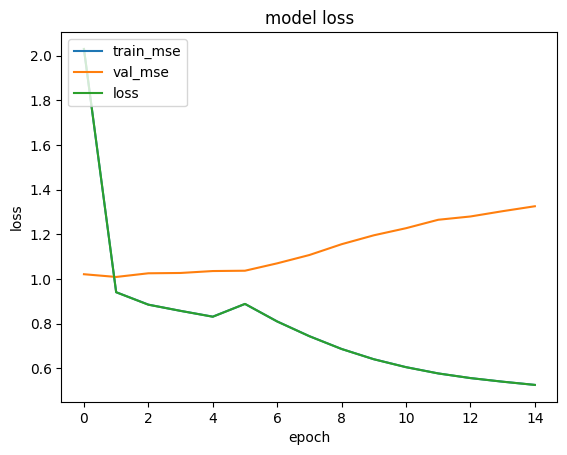

In [30]:
# print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['mse'])
# plt.plot(history.history['val_mse'])
# plt.plot(history.history['loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train_mse', 'val_mse','loss'], loc='upper left')
# plt.show()
# # summarize history for loss
#plt.plot(history.history['loss'])

# Book

In [9]:
# data = pd.read_csv("../hw3_data/Movielens/movielens_sample.csv")
data = pd.read_csv("../hw3_data/Douban_Book/Douban_Book_sample.csv")

data

,user,book,author,publisher,year,group,location,userrating
0,10855,938,4387,944,20,232|9|68|832|888|320|1013|205|1968|1365|78|293...,33,4
1,10027,3,9486,1743,14,9|226|43|68|1183|360|73|2113|186|2463|519|253|...,394,3
2,741,2426,10548,1475,21,108|62|78|483|39|1877|70|556|439|356|744|960|1...,13,5
3,453,1263,10314,431,35,232|1878|751|39|70|776|376|1531|2702|989|1002|...,33,4
4,11665,7717,5720,1049,18,76|232|9|554|893|1338|287|2597|68|360|605|1691...,0,5
...,...,...,...,...,...,...,...,...
792057,12832,2650,10651,1273,36,1326|1428|327|1224|1773|2575|575|77|93|318|168...,33,5
792058,7823,3050,7195,1331,8,9|344|228|124|43|1258|378|73|1206|907|660|998|...,413,4
792059,9347,18017,5243,1769,18,76|666|893|344|43|403|360|2113|186|1423|423|62...,13,5
792060,10942,1443,8378,1792,20,1374|9|1365|269|2258|139|1731|1134|2682|1178|8...,373,4


In [10]:
sparse_features = ['user', 'book', 'author', 'publisher', 'year', 'location']
dense_features = ['group']

target = ['userrating']
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

key2index = {}
group_list = list(map(split_data, data['group'].values))
group_length = np.array(list(map(len, group_list)))
max_len = max(group_length)
# Notice : padding=`post`
group_list = pad_sequences(group_list, maxlen=max_len, padding='post', )

fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=4) for feat in sparse_features]
varlen_feature_columns = [VarLenSparseFeat(SparseFeat( 'group', vocabulary_size=len(key2index) + 1, embedding_dim=4) , maxlen=max_len, combiner='mean')] 

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dict = {"IPNN":PNN(dnn_feature_columns,use_inner=True,use_outter=False,task='regression',device=device),
              "OPNN":PNN(dnn_feature_columns,use_inner=False,use_outter=True,task='regression',device=device),
              "PNN":PNN(dnn_feature_columns,use_inner=True,use_outter=True,task='regression',device=device),
              "CCPM":CCPM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
              "WDL":WDL(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "DCN":DCN(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "NFM":NFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "DeepFM":DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "AFM":AFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
             "xDeepFM":xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device)}

In [ ]:
rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=42)
store_final_result = {}
for model_name,model_ in model_dict.items():
        
    RMSE_M = []
    recall_M = []
    NDCG_M = []
    print(model_name)
    # 3.generate input data for model
    for i, (train_index, test_index) in enumerate(rs.split(data)):
        model_dict = {"IPNN":PNN(dnn_feature_columns,use_inner=True,use_outter=False,task='regression',device=device),
                      "OPNN":PNN(dnn_feature_columns,use_inner=False,use_outter=True,task='regression',device=device),
                      "PNN":PNN(dnn_feature_columns,use_inner=True,use_outter=True,task='regression',device=device),
                      "CCPM":CCPM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "WDL":WDL(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "DCN":DCN(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "NFM":NFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "DeepFM":DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "AFM":AFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device),
                      "xDeepFM":xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression',device=device)}
        X_train, y_train = data.iloc[train_index], data.iloc[train_index]['userrating']  
        X_test, y_test = data.iloc[test_index], data.iloc[test_index]['userrating']

        train_model_input = {name: X_train[name] for name in sparse_features}
        train_model_input["group"] = group_list[train_index]
        
        test_model_input = {name: X_test[name] for name in sparse_features}
        test_model_input["group"] = group_list[test_index]
        
        model = model_dict[model_name]

        model.compile("adam", "mse", metrics=['mse','recall'], )
        history = model.fit(train_model_input,y_train.values,batch_size=256,epochs=5,verbose=2,validation_split=0.2)
        pred_ans = model.predict(test_model_input, batch_size=256)

        RMSE = mean_squared_error(pred_ans,y_test, squared=False)
        RMSE_M.append(RMSE)
        recall = recall_score(np.round(pred_ans),y_test, average='micro')
        recall_M.append(recall)
        NDCG = ndcg_score(pred_ans.reshape(1, -1),y_test.values.reshape(1, -1), k=10)
        NDCG_M.append(NDCG) 
        print(f"RMSE: {RMSE}, Recall: {recall}, NDCG: {NDCG}")
    print(f"Average RMSE: {Average(RMSE_M)}, Average Recall: {Average(recall_M)}, Average NDCG: {Average(NDCG_M)}")    
    store_final_result[model_name] = f"Average RMSE: {Average(RMSE_M)}, Average Recall: {Average(recall_M)}, Average NDCG: {Average(NDCG_M)}"

#0.8353, Average Recall: 0.4685, Average NDCG: 0.7758
with open('final_result_book.txt', 'w') as file:
    file.write(json.dumps(store_final_result))

IPNN
cuda
Train on 570284 samples, validate on 142571 samples, 2228 steps per epoch
Epoch 1/5
28s - loss:  0.7758 - mse:  0.7758 - val_mse:  0.4900
Epoch 2/5
27s - loss:  0.4686 - mse:  0.4686 - val_mse:  0.4793
Epoch 3/5
27s - loss:  0.4486 - mse:  0.4486 - val_mse:  0.4790
Epoch 4/5
28s - loss:  0.4338 - mse:  0.4338 - val_mse:  0.4786
Epoch 5/5
27s - loss:  0.4198 - mse:  0.4198 - val_mse:  0.4830
RMSE: 0.6936497305765859, Recall: 0.5340689585516432, NDCG: 0.7535509920895874
cuda
Train on 570284 samples, validate on 142571 samples, 2228 steps per epoch
Epoch 1/5
27s - loss:  0.7735 - mse:  0.7735 - val_mse:  0.4933
Epoch 2/5
27s - loss:  0.4678 - mse:  0.4678 - val_mse:  0.4992
Epoch 3/5
29s - loss:  0.4445 - mse:  0.4445 - val_mse:  0.4838
Epoch 4/5
28s - loss:  0.4245 - mse:  0.4245 - val_mse:  0.4904
Epoch 5/5
26s - loss:  0.4070 - mse:  0.4070 - val_mse:  0.4945
RMSE: 0.7042999245529744, Recall: 0.5290441501382454, NDCG: 0.7620308155166179
cuda
Train on 570284 samples, validate 

# source code

In [40]:
data = pd.read_csv('./criteo_sample.txt')

sparse_features_clo = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

data
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
data
feat
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]
fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(fixlen_feature_columns + fixlen_feature_columns)
feature_names
dnn_feature_columns
len(feature_names)
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name:train[name] for name in feature_names}

test_model_input = {name:test[name] for name in feature_names}
train_model_input